# Домашнее задание 2. Преобразование данных

Цель этого задания -- преобразовать имеющиеся атрибуты пользователей в признаки так, чтобы полученная матрица признаков была пригодна для подачи в алгоритм кластеризации. Этап конструирования признаков -- самый важный и обычно самый долгий. К нему возвращаются много раз на протяжении решения задачи анализа данных.

Кроме библиотек, использованных в первом задании, нам понадобятся следующие библиотеки:
1. [scikit-learn](http://scikit-learn.org/stable/) -- библиотека, реализующая множество алгоритмов машинного обучения и сопутствующих алгоритмов

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as pl
import sklearn.preprocessing as sp
import csv
import re
import dateutil

np.set_printoptions(linewidth=150, precision=3, suppress=True)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None
df_users = pd.read_csv("hw1_out.csv", sep="\t", encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC, converters={"created_at": ts_parser})
# Remove rows with users not found
df_users = df_users[pd.notnull(df_users['name'])]
df_users["lat"].fillna(value=0, inplace=True)
df_users["lon"].fillna(value=0, inplace=True)

Далее необходимо ввести новые признаки. Для каждого пользователя предлагается ввести следующие признаки:
- name_words - количество слов в имени
- screen_name_length - количество символов в псевдониме
- description_length - длина описания
- created_year - год создания аккаунта
- country_code - код страны
- verified - предлагается перевести в тип int

In [3]:
def create_new_features(df_users, features):
    new_features = ["name_words", "screen_name_length", "description_length", "created_year", "country_code", "verified"]
    
    features += new_features
    
    nf_names = ["twitter_id", "name", "screen_name", "description", "created_at", "country", "verified"]
    nf = []
    
    # NOTE: I've tested 2 types of generating country code, and here is no big difference
    # countries = list(set(df_users['country']))
    # country_code = dict(zip(sort(countries), range(len(countries))))

    for usr in df_users[nf_names].values:
        nf.append({
                "twitter_id": usr[0],
                "name_words": len(usr[1].split(' ')),
                "screen_name_length": len(usr[2]),
                "description_length": len(usr[3].split(' ')) if usr[3] is not np.NaN else 0,
                "created_year": usr[4].year,
                "country_code": hash(usr[5]), #country_code[usr[5]] if usr[5] is not np.NaN else 0,
                "verified": 1 if usr[6] else 0,
            })
    
    df_nf = pd.DataFrame(nf, columns=['twitter_id'] + new_features)
    df_users = df_users.drop("verified", axis=1)
    df_users = pd.merge(df_users, df_nf, on="twitter_id", how="left")
    
    return df_users, features

In [4]:
features = ["lat", "lon", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"]
df_users, features = create_new_features(df_users, features)

def f(x):
    if x[0] == 1:
        return 1
    if x[1] == 1:
        return 2
    if x[2] == 1:
        return 3

x = df_users[features].values
y = df_users[['is_1', 'is_2', 'is_3']].apply(f, axis=1)

Посмотрим, являются ли какие-либо из выбранных признаков сильно скоррелированными. Для этого посчитаем матрицу корреляций и выберем те пары признаков, фбсолютное значения коэффициента корреляции между которыми больше 0.2. Необходимо реализовать функцию find_correlated_features, в которой нужно рассчитать коэффициенты корелляции и вывести те, которые больше 0.2. Подсказка: предлагается найти необходимую функцию в библиотеке np и реализовать find_correlated_features с использованием не более 5 строк кода.

In [5]:
def find_correlated_features(x, features):
    corcoef = np.corrcoef(x.T)
    for i, feature_i in enumerate(features):
        for j, feature_j in enumerate(features):
            if i < j and np.abs(corcoef[i, j]) > 0.2:
                print "Correlated features: %s + %s -> %.2f" % (feature_i, feature_j, corcoef[i, j])
    

In [6]:
find_correlated_features(x, features)

Correlated features: lat + lon -> -0.62
Correlated features: lat + country_code -> -0.28
Correlated features: lon + country_code -> 0.71
Correlated features: followers_count + friends_count -> 0.21
Correlated features: followers_count + listed_count -> 0.82
Correlated features: followers_count + verified -> 0.29
Correlated features: statuses_count + favourites_count -> 0.32
Correlated features: statuses_count + created_year -> -0.21
Correlated features: listed_count + verified -> 0.35


Выделилось 3 группы признаков:
1. Основанные на географии:  "lat", "lon", "country_code"
2. Основанные на социальной активности:  "verified", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count", "created_year"
3. Остальные:  "name_words", "screen_name_length", "description_length"

Построим взаимные распределения пар признаков в каждой из групп, а также гистограмму значений каждого из признаков с учетом целевой переменной.

Необходимо реализовать функции: plot_two_features_scatter для построения взаимного распределения пары признаков, plot_feature_histogram для построения гистограммы значений, plot_dataset для построения набора графиков по разным парам признаков.

In [7]:
def plot_two_features_scatter(x_i, x_j, y):
    is1, is2, is3 = np.where(y == 1)[0], np.where(y == 2)[0], np.where(y == 3)[0]
    pl.scatter(x_i[is1], x_j[is1], c='g', linewidths=0.1, alpha=0.7, s=10)
    pl.scatter(x_i[is2], x_j[is2], c='r', linewidths=0.1, alpha=0.7, s=10)
    pl.scatter(x_i[is3], x_j[is3], c='b', linewidths=0.1, alpha=0.5, s=10)

    
def plot_feature_histogram(x_i, y):
    
    is1, is2, is3 = np.where(y == 1)[0], np.where(y == 2)[0], np.where(y == 3)[0]
    pl.hist([x_i[is1], x_i[is2], x_i[is3]],
            color=['r', 'g', 'b'], alpha=0.7, edgecolor="none")
    

def plot_dataset(x, y, features):
    
    pl.rcParams['figure.figsize'] = 25, 25
    w = len(features)

    for i, feature_i in enumerate(features):
        for j, feature_j in enumerate(features):
            pl.subplot(w, w, j * w + i + 1)
            pl.xticks([])
            pl.yticks([])
            if (i == 0):
                pl.ylabel(feature_j, size=15)
            if (j == 0):
                pl.title(feature_i, size=15)

            if i != j:
                plot_two_features_scatter(x[:, i], x[:, j], y)            
            else:
                plot_feature_histogram(x[:, i], y)
    
    pl.show()

Построим попарные распределения географических признаков ([подсказка](http://anokhin.github.io/img/hw2_geo.png)).

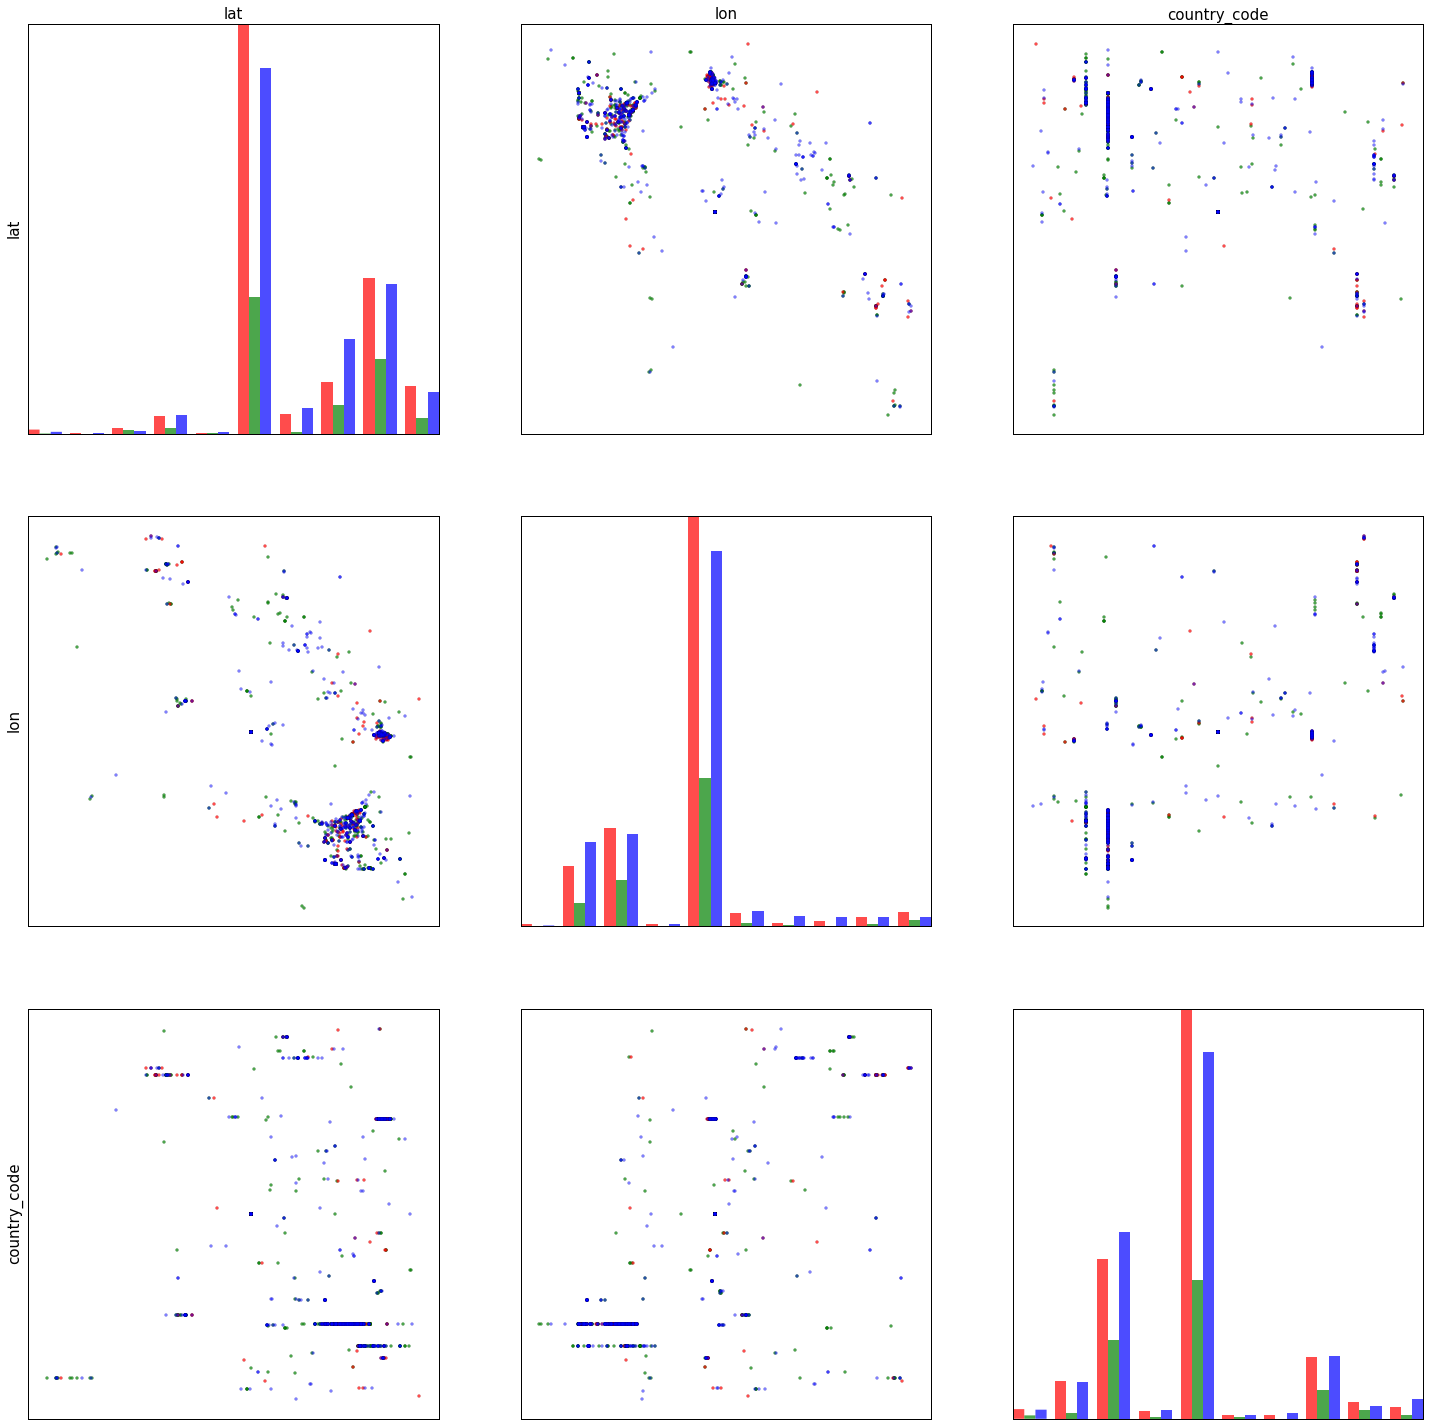

In [8]:
geo_features = ["lat", "lon", "country_code"]
# geo_features = [f for f in features if f in geo_features_new]

geo_feature_ind = [features.index(f) for f in geo_features]
plot_dataset(x[:, geo_feature_ind], y, geo_features)

Четко видны очертания карты и то, что большинство пользователей происходят из небольшого набора стран. Если принять во внимание конечную цель -- кластеризацию пользователей -- логично предположить, что использование географических признаков для описания пользователя может оказаться не очень полезным. Причина в том, что эти признаки четко пространственно разделены (как минимум, океанами и морями). Поэтому мы рискуем вместо "интересной" кластеризации получить просто кластеры, которые будут представлять разные страны. В дальнейшем мы исключим географические признаки из рассмотрения при кластеризации пользователей.

Далее построим попарные распределения социальных признаков ([подсказка](http://anokhin.github.io/img/hw2_social1.png)).

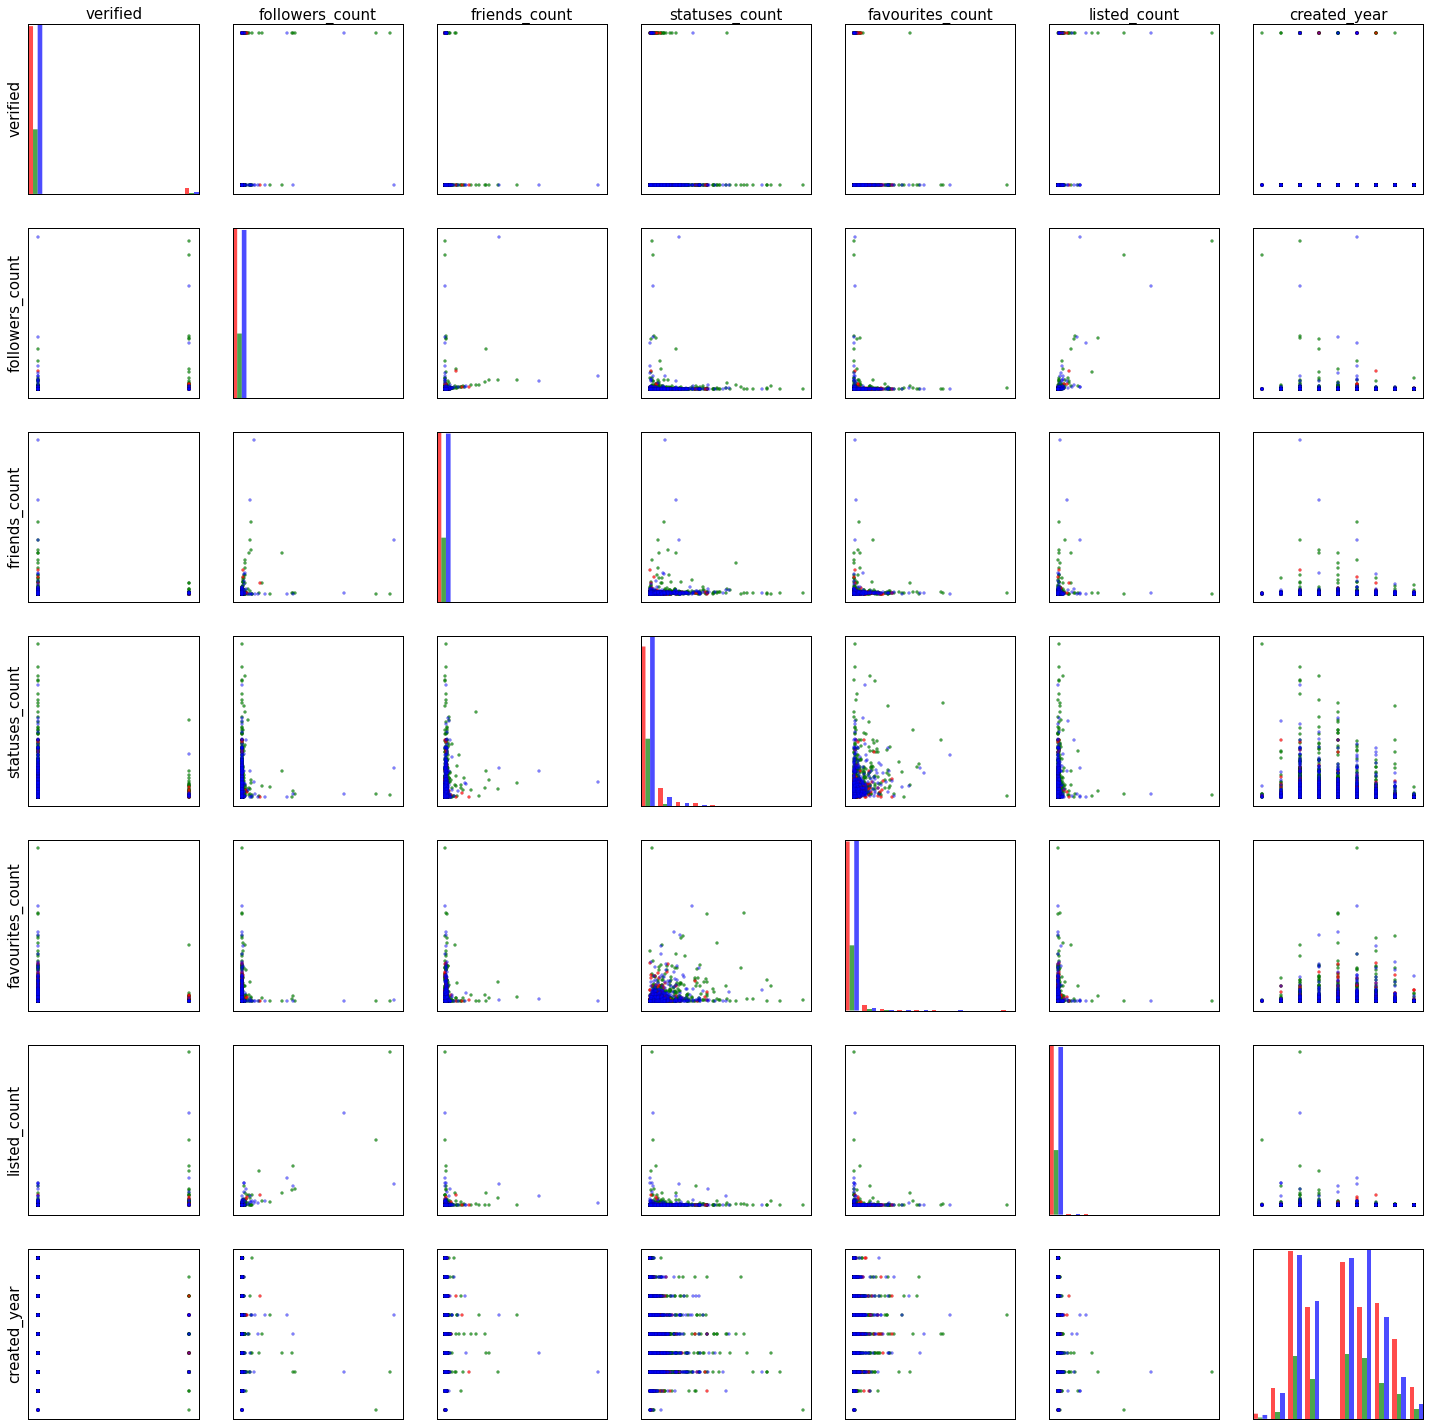

In [9]:
social_features = ["verified", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count", "created_year"]
# social_features = [f for f in features if f in social_features_new]
# NOTE: social_features = [f for f in social_features_new if f in features] - incorrect
# NOTE: order of indexs and features aren't the same
social_feature_ind = [features.index(f) for f in social_features]
plot_dataset(x[:, social_feature_ind], y, social_features)

Из графиков видно, что признаки "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count" сильно смещены в сторону небольших значений. В таком случае удобно сделать логарифмическое преобразрвание этих признаков, то есть применить к их значениям $x_{ij}$ функцию $\log(1 + x_{ij})$. Сделаем это и построим новые распределения ([подсказка](http://anokhin.github.io/img/hw2_social2.png)). Необходимо реализовать функцию log_transform_features, которая выполняет указанное логарифмическое преобразование.

In [10]:
def log_transform_features(data, features, transformed_features):
    ind = [features.index(f) for f in transformed_features]
    x[:, ind] = np.log(1 + x[:, ind])
    return data

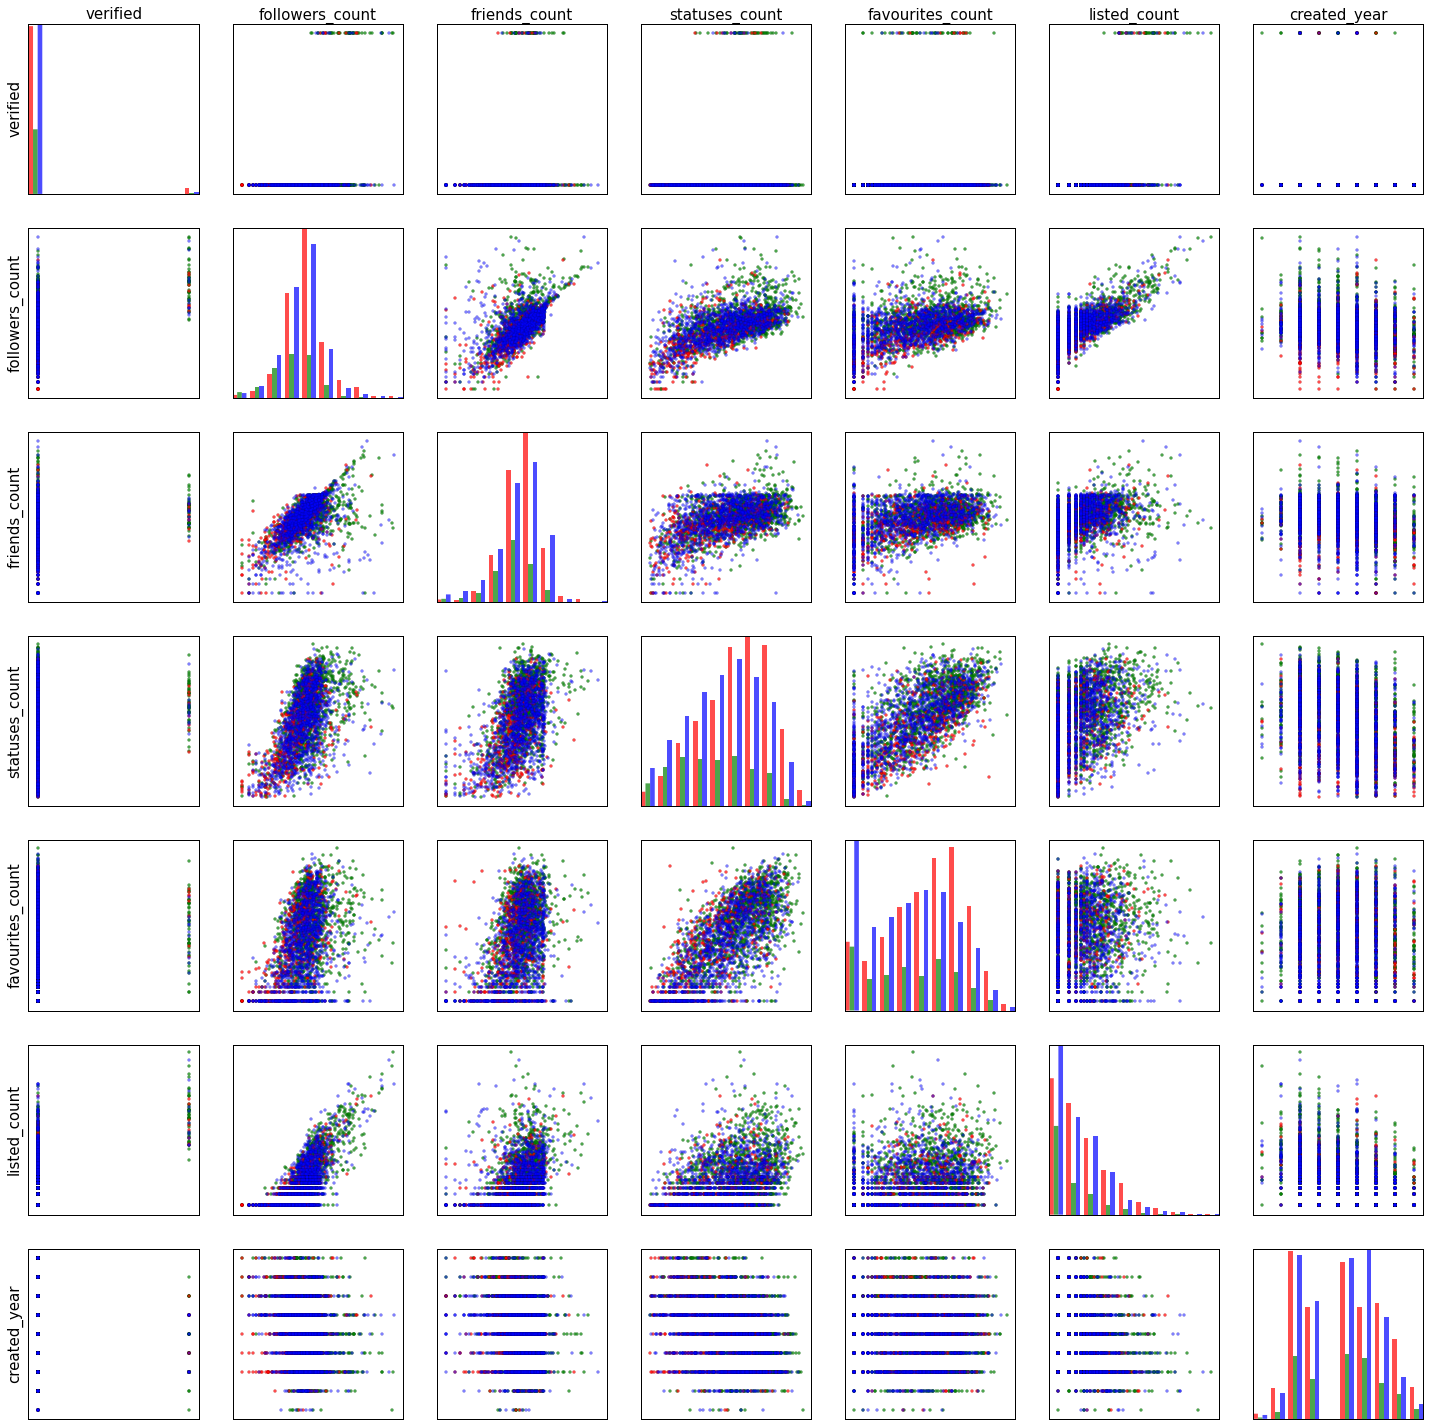

In [11]:
transformed_features = ["followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"]
x = log_transform_features(x, features, transformed_features)

# Re-plot features
plot_dataset(x[:, social_feature_ind], y, social_features)

Сразу бросается в глаза, что признак "verified" сильно смещен -- верифицированных пользователей очень мало. Более того, все верифицированные пользователи имеют много фолловеров, поэтому часть информации о верификации дублируется в признаке "followers_count". По этой причине в дальнейшем не будем рассмтаривать признак "verified".

После того как мы с помощью логарифмического преобразования избавились от сильной скошенности признаков, можно наблюдать некоторые интересные зависимости. Например, пользователи, имеющие много фолловеров, обязательно имеют много статусов. Следовательно, чтобы стать популярным, обязательно нужно много писать. Анализ других зависимостей остается как упражнение.

Наконец построим попарные распределения остальных признаков ([подсказка](http://anokhin.github.io/img/hw2_other.png)).

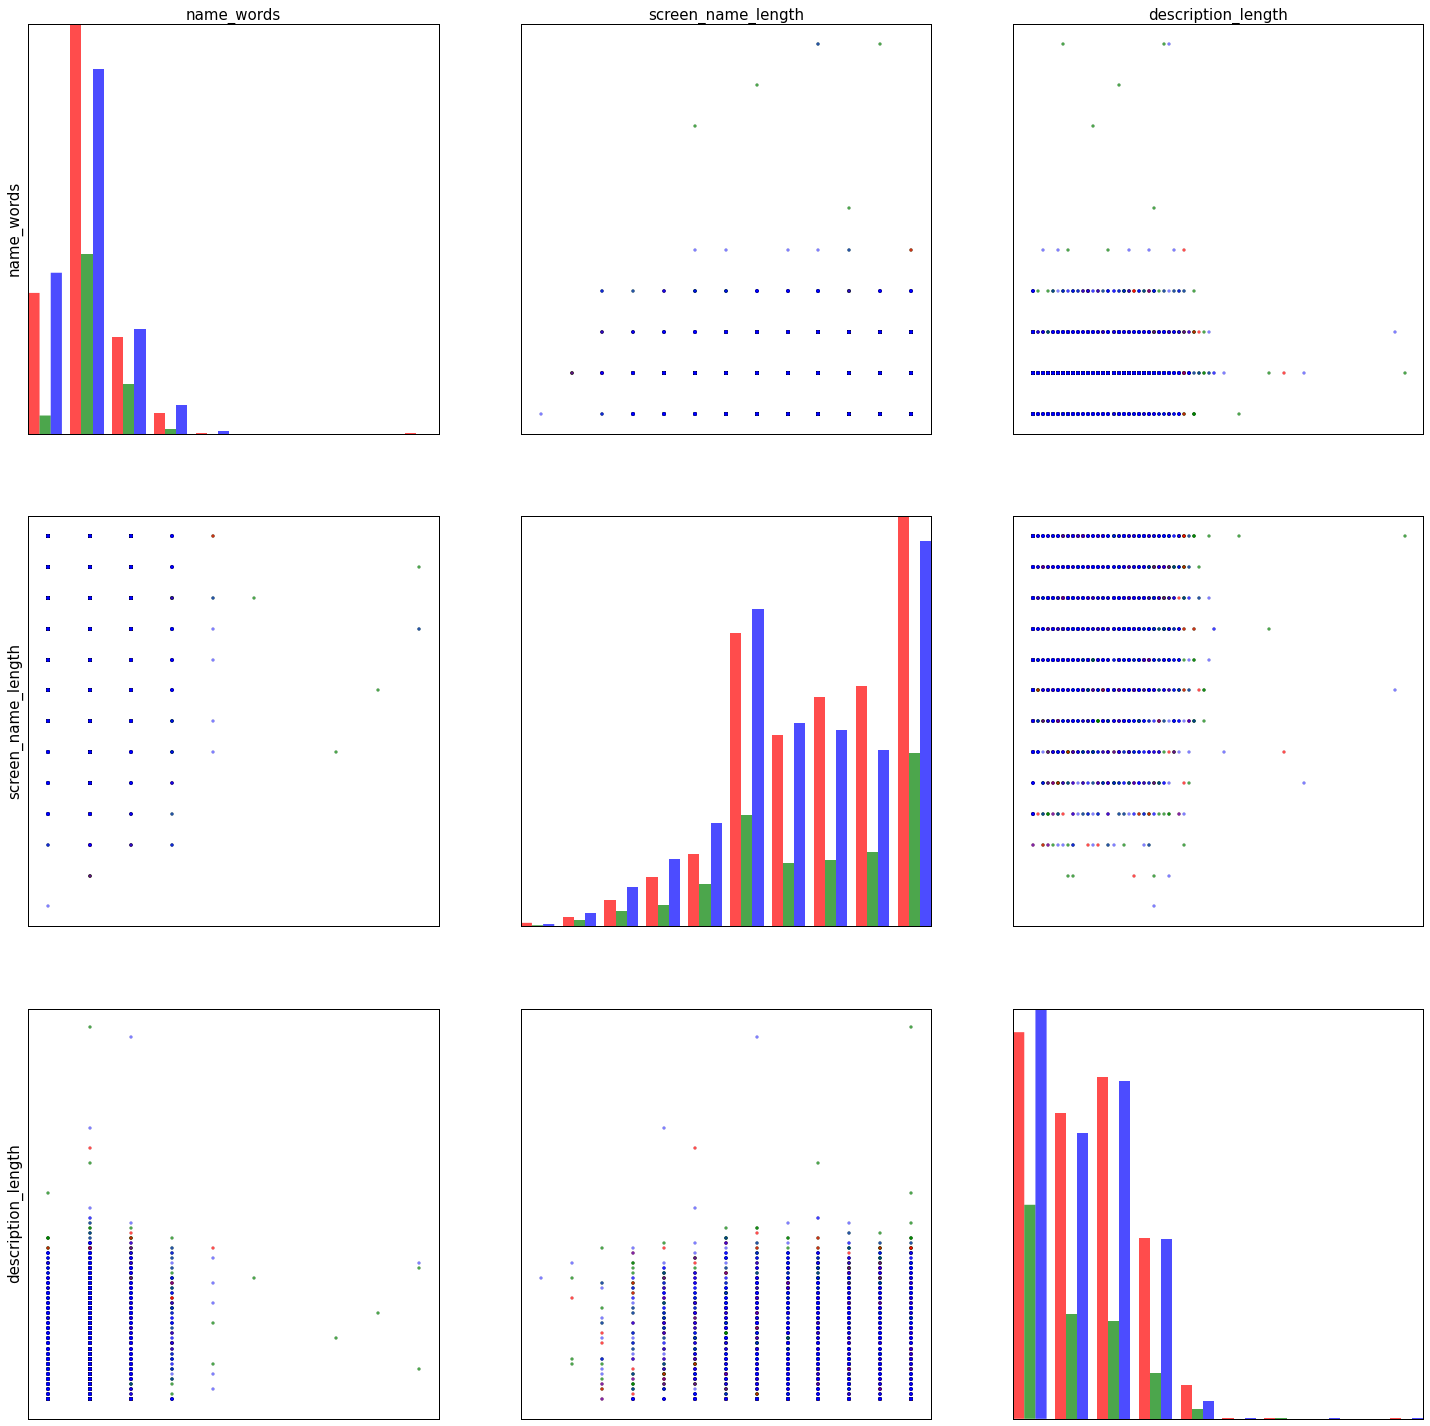

In [12]:
other_features = ["name_words", "screen_name_length", "description_length"]
# other_features = [f for f in features if f in other_features_new]
other_feature_ind = [features.index(f) for f in other_features]
plot_dataset(x[:, other_feature_ind], y, other_features)

Итак после первичной обработки данных мы имеем 9 числовых признаков, каждый из которых распределен в некотором своем интервале. Для того, чтобы ни один признак не получил перевеса при кластеризации, нормализуем данные так, что каждый признак распределен на отрезке $[0, 1]$. 

In [13]:
selected_features = ["followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count", "created_year", "name_words", "screen_name_length", "description_length"]
selected_features_ind = [features.index(f) for f in selected_features]

x_1 = x[:, selected_features_ind]

# Replace nan with 0-s
# Is there a smarter way?
# ANS: We could replace them with mean value
x_1[np.isnan(x_1)] = 0 # np.tile(x_1.mean(axis=0), (x_1.shape[0], 1))[np.isnan(x_1)]
x_min = x_1.min(axis=0)
x_max = x_1.max(axis=0)
x_new = (x_1 - x_min) / (x_max - x_min)

Упакуем полученную матрицу в pandas DataFrame и сохраним в файл "hw2_out.csv". В следующем задании мы будем кластеризовать пользователей на оновании этих данных.

In [14]:
df_out = pd.DataFrame(data=x_new, index=df_users["twitter_id"], columns=selected_features)
df_out.to_csv("hw2_out.csv", sep="\t")

In [15]:
df_out.head()

,followers_count,friends_count,statuses_count,favourites_count,listed_count,created_year,name_words,screen_name_length,description_length
twitter_id,,,,,,,,,
66412773,0.517191,0.641621,0.841134,0.520378,0.493755,0.25,0.111111,0.416667,0.324324
10143902,0.446671,0.530160,0.463346,0.315970,0.419833,0.00,0.111111,0.666667,0.175676
73701917,0.492312,0.389425,0.758393,0.542286,0.342908,0.25,0.222222,0.166667,0.108108
82209363,0.374649,0.470271,0.656510,0.724549,0.072952,0.25,0.111111,0.916667,0.175676
47063951,0.522886,0.630535,0.720260,0.845083,0.320430,0.25,0.222222,0.583333,0.351351
